# 🤖 Modelado Supervisado H2O + GPU + Paralelo - Precios Inmobiliarios Dinamarca

**Objetivo**: Construir modelos distribuidos H2O, clásicos sklearn y de árbol con optimizaciones GPU y paralelización, evaluarlos con métricas sólidas considerando rendimiento y velocidad.

1. División de Datos (Temporal)

    1.1 Split temporal (80% train, 20% test)

    1.2 Validación de distribución en train/test

    1.3 Visualización de drift o cambios en el tiempo (si aplica)

2. Modelos Estadísticos

    2.1 Regresión Lineal, Ridge, Lasso, ElasticNet

    2.2 Ajuste con mínimos cuadrados o likelihood

    2.3 Comparación de modelos con AIC/BIC (sin CV)

    2.4 Diagnóstico de residuos y detección de outliers

3. Modelos de Árboles

    3.1 LightGBM y Random Forest (hiperparámetros por defecto o mínimos)

    3.2 Comparación con modelos estadísticos

    3.3 Feature importance y explicabilidad inicial

6. Evaluación General

    6.1 Métricas: RMSE, MAE, MAPE, R²

    6.2 Visualización de errores (residuos, pred vs real)

    6.3 Análisis por segmentos (tipo de casa, región)

    6.4 Tabla resumen de modelos y conclusiones

## Requistos previos

```
feature_engineered_complete.parquet, modeling_dataset.parquet, train_data.parquet, test_data.parquet

scalers.pkl, selected_features.txt
```

Obtener los datos de `04_feature_engineering.ipynb` 

In [1]:
from setup import set_project_root
set_project_root()

from config import *
from descriptive_analysis import (
    load_and_validate_data,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings




Current working directory: /home/exodia/Documentos/TFBigData


## 1. División de Datos (Temporal)

### 1.1 Split temporal (80% train, 20% test)

Se cargan los datos generados en la extracción de características.

In [2]:
import h2o 
from h2o.estimators import H2OXGBoostEstimator
from joblib import load
import pandas as pd


In [3]:

# 🚀 Iniciar H2O
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.8" 2023-07-18; OpenJDK Runtime Environment Temurin-17.0.8+7 (build 17.0.8+7); OpenJDK 64-Bit Server VM Temurin-17.0.8+7 (build 17.0.8+7, mixed mode, sharing)
  Starting server from /home/exodia/miniconda3/envs/TFBigData/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuu4z9piq
  JVM stdout: /tmp/tmpuu4z9piq/h2o_exodia_started_from_python.out
  JVM stderr: /tmp/tmpuu4z9piq/h2o_exodia_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 16 days
H2O_cluster_name:,H2O_from_python_exodia_6o87yw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.723 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4]:

# 📦 Cargar datos en pandas y escalar
train = pd.read_parquet(TRAIN_DATA_FILE)
test = pd.read_parquet(TEST_DATA_FILE)

features = open(SELECTED_FEATURES_FILE).read().splitlines()
scalers = load(SCALERS_FILE)


In [7]:
train.describe()


,price_deviation_from_median,log_price,price_per_sqm,price_per_sqm_x_region,is_premium,time_trend,year,quarter,property_age,sqm,...,region_target_encoded,age_x_villa,region_count,region_frequency,rooms_sqm_ratio,sqm_x_region,sqm_per_room,no_rooms,rooms_sqm_interaction,purchase_price
count,8.931120e+05,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,...,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,8.931120e+05
mean,1.289758e+05,13.974267,0.084428,0.149188,0.060528,0.450166,2006.405302,147.149546,0.260460,0.125885,...,-0.023174,0.115536,628516.523630,-0.801215,0.106726,-0.067321,0.140828,0.050920,0.632038,1.573563e+06
std,1.466773e+06,0.746640,0.798566,0.796118,0.238462,0.221997,7.103908,28.496608,0.927277,0.813850,...,0.993301,0.653684,187311.727007,1.184820,0.943875,0.801108,1.174300,1.012637,1.500242,1.489907e+06
min,-1.593968e+06,12.429260,-0.805018,-8.047822,0.000000,0.000000,1992.000000,88.000000,-1.204082,-1.366197,...,-1.870324,-1.204082,15893.000000,-4.676298,-3.193390,-22.601943,-3.005714,-2.042926,-17.689896,2.500100e+05
25%,-6.900000e+05,13.434252,-0.436405,-0.207323,0.000000,0.281250,2001.000000,125.000000,-0.265306,-0.450704,...,-0.777622,-0.061224,597090.000000,-1.000000,-0.472207,-0.525716,-0.457143,-0.831176,0.035120,6.830000e+05
50%,-2.486208e+05,13.953097,-0.167453,0.190533,0.000000,0.468750,2007.000000,149.000000,0.020408,0.042254,...,-0.777622,0.000000,755183.000000,0.000000,0.000000,-0.065715,0.000000,-0.225302,0.214407,1.147500e+06
75%,5.000000e+05,14.483340,0.313116,0.425091,0.000000,0.656250,2013.000000,173.000000,0.755102,0.549296,...,1.226500,0.081633,755183.000000,0.000000,0.532020,0.383335,0.548571,0.380573,0.740093,1.950000e+06
max,4.475500e+07,17.644152,4.323574,5.302862,1.000000,0.781250,2017.000000,191.000000,19.693878,12.309859,...,1.226500,19.693878,755183.000000,0.000000,32.389163,15.098038,80.342857,6.439319,75.185853,4.600000e+07


In [8]:
test.describe()

,price_deviation_from_median,log_price,price_per_sqm,price_per_sqm_x_region,is_premium,time_trend,year,quarter,property_age,sqm,...,region_target_encoded,age_x_villa,region_count,region_frequency,rooms_sqm_ratio,sqm_x_region,sqm_per_room,no_rooms,rooms_sqm_interaction,purchase_price
count,6.134790e+05,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,...,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,6.134790e+05
mean,9.499608e+05,14.419053,0.608882,0.392892,0.155524,0.901957,2020.862638,204.881360,0.124803,0.033467,...,0.033736,0.055963,627399.226723,-0.808282,0.131425,-0.103849,0.117547,-0.074130,0.596004,2.412784e+06
std,1.943399e+06,0.755822,1.027324,1.262376,0.362404,0.057924,1.853566,7.381032,0.941828,0.790330,...,1.008723,0.633803,183170.229358,1.158623,0.966108,0.782793,1.110821,0.976578,1.350907,2.001308e+06
min,-1.593922e+06,12.429540,-0.795691,-8.086483,0.000000,0.812500,2018.000000,192.000000,-1.204082,-1.366197,...,-1.870324,-1.204082,15893.000000,-4.676298,-3.211410,-11.801481,-3.019048,-2.042926,-20.860860,2.500800e+05
25%,-2.870000e+05,13.910822,-0.152395,-0.270564,0.000000,0.843750,2019.000000,199.000000,-0.408163,-0.535211,...,-0.777622,-0.040816,597090.000000,-1.000000,-0.467980,-0.586878,-0.457143,-0.831176,0.038079,1.100000e+06
50%,4.559975e+05,14.444120,0.320265,0.146759,0.000000,0.906250,2021.000000,205.000000,-0.061224,-0.056338,...,-0.777622,0.000000,597090.000000,-1.000000,0.000000,-0.098572,0.000000,-0.225302,0.219767,1.875000e+06
75%,1.600000e+06,14.946913,1.099234,0.727490,0.000000,0.937500,2022.000000,211.000000,0.612245,0.464789,...,1.226500,0.000000,755183.000000,0.000000,0.532020,0.361430,0.542857,0.380573,0.737523,3.100000e+06
max,4.495600e+07,17.661394,4.323574,5.302862,1.000000,1.000000,2024.000000,218.000000,19.693878,12.295775,...,1.226500,19.693878,755183.000000,0.000000,34.002066,15.080763,93.600000,6.439319,58.607685,4.680000e+07


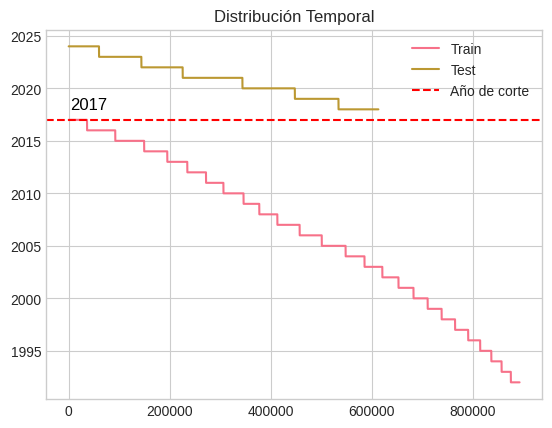

In [9]:
# grafico comparativo de la variable temporal
plt.plot(train['year'], label="Train")
plt.plot(test['year'], label="Test")

## anadir una linea horizonalt en el 2017
plt.axhline(y=2017, color='r', linestyle='--', label='Año de corte')
plt.text(2017, 2018, '2017', color='black', fontsize=12)
plt.legend()
plt.title("Distribución Temporal")
plt.show()

Validamos que nuestro dataset cumpla con las condiciones de tiempo y que no haya fugas de datos entre train y test.


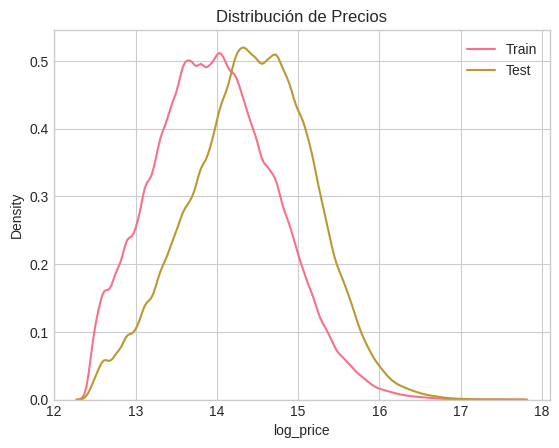

In [10]:
sns.kdeplot(train['log_price'], label='Train')
sns.kdeplot(test['log_price'], label='Test')
plt.title("Distribución de Precios")
plt.legend()
plt.show()


In [11]:
import optuna
import h2o
import pandas as pd
from joblib import load, dump
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import partial
from h2o.estimators import H2OXGBoostEstimator


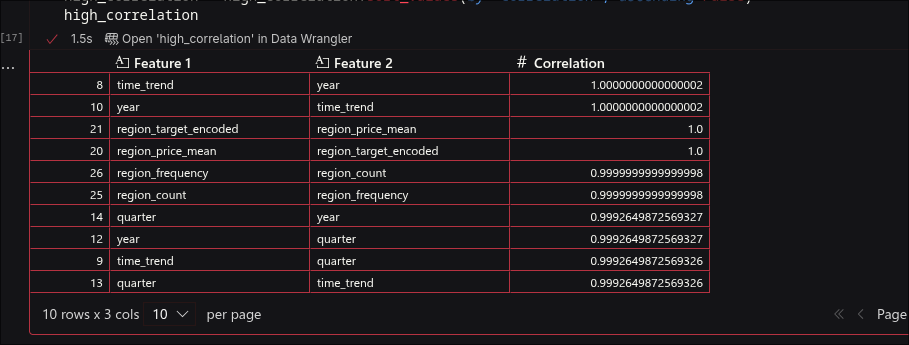

In [28]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 🔧 FUNCIONES
def load_scaled_data(target=TARGET):
    # 1. Cargar features seleccionados
    selected_features = open(SELECTED_FEATURES_FILE).read().splitlines()
    
    exclude_features = [TARGET, "quarter", "region_count", "price_deviation_from_median", "time_trend", "region_target_encoded", "region_count"]
    
    selected_features = [f for f in selected_features if f not in exclude_features]

    # 2. Cargar datasets
    train = pd.read_parquet(TRAIN_DATA_FILE)
    test = pd.read_parquet(TEST_DATA_FILE)

    # 3. Separar X e y
    
    
    X_train_raw = train[selected_features]
    X_test_raw = test[selected_features]
    
    y_train = train[target].reset_index(drop=True)
    y_test = test[target].reset_index(drop=True)

    # 4. Escalar X con StandardScaler
    scaler = StandardScaler().fit(X_train_raw)
    X_train = pd.DataFrame(scaler.transform(X_train_raw), columns=selected_features)
    X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=selected_features)
    
    if TARGET in X_train.columns:
        X_train = X_train.drop(columns=[TARGET])
        X_test = X_test.drop(columns=[TARGET])


    return X_train, X_test, y_train, y_test, selected_features, scaler


In [29]:
# 📦 CARGAR DATA
X_train, X_test, y_train, y_test, features, scaler = load_scaled_data(target=TARGET)


In [25]:
X_train.corr()

,price_deviation_from_median,price_per_sqm,price_category_Premium,price_category_Medium,price_per_sqm_x_region,price_category_High,is_premium,time_trend,year,quarter,...,sales_type_regular_sale,sales_type_family_sale,rooms_sqm_ratio,sqm_x_region,sqm_per_room,no_rooms,size_category_Large,rooms_sqm_interaction,house_type_Summerhouse,phase_boom_2000s
price_deviation_from_median,1.000000,0.724510,0.715421,-0.194313,0.084505,0.083361,0.707907,0.256918,0.256918,0.256548,...,0.044064,-0.040579,-0.153445,0.083148,0.127375,0.180600,0.177291,0.203240,-0.143167,-0.025433
price_per_sqm,0.724510,1.000000,0.661324,-0.177241,0.059842,0.125214,0.560183,0.263372,0.263372,0.263283,...,0.041815,-0.059706,0.044353,0.088004,-0.039105,-0.260159,-0.205421,0.020551,-0.030731,-0.023628
price_category_Premium,0.715421,0.661324,1.000000,-0.280384,0.129320,-0.241885,0.561847,0.221425,0.221425,0.221253,...,0.040312,-0.042217,-0.111179,0.101827,0.087853,0.091242,0.108109,0.090719,-0.114367,-0.044201
price_category_Medium,-0.194313,-0.177241,-0.280384,1.000000,-0.059767,-0.333634,-0.157849,-0.039413,-0.039413,-0.039464,...,0.026118,-0.012891,0.010507,-0.045114,-0.019278,-0.008176,-0.018934,-0.029667,0.008637,0.040085
price_per_sqm_x_region,0.084505,0.059842,0.129320,-0.059767,1.000000,-0.039469,-0.094802,0.093244,0.093244,0.093180,...,0.040182,-0.022379,-0.021795,-0.190922,0.009508,0.049788,0.030995,-0.010754,-0.055507,-0.005692
price_category_High,0.083361,0.125214,-0.241885,-0.333634,-0.039469,1.000000,-0.135161,0.153416,0.153416,0.153123,...,0.066441,-0.057729,-0.049735,-0.014602,0.017856,0.034251,0.037204,-0.001537,-0.067610,0.023947
is_premium,0.707907,0.560183,0.561847,-0.157849,-0.094802,-0.135161,1.000000,0.116832,0.116832,0.116704,...,-0.011932,0.001789,-0.090453,0.042793,0.087151,0.091145,0.102857,0.134569,-0.068046,-0.032547
time_trend,0.256918,0.263372,0.221425,-0.039413,0.093244,0.153416,0.116832,1.000000,1.000000,0.999265,...,-0.027272,-0.008862,-0.006131,-0.009806,0.007781,-0.044902,-0.021449,-0.009457,0.046174,-0.195630
year,0.256918,0.263372,0.221425,-0.039413,0.093244,0.153416,0.116832,1.000000,1.000000,0.999265,...,-0.027272,-0.008862,-0.006131,-0.009806,0.007781,-0.044902,-0.021449,-0.009457,0.046174,-0.195630
quarter,0.256548,0.263283,0.221253,-0.039464,0.093180,0.153123,0.116704,0.999265,0.999265,1.000000,...,-0.027776,-0.008351,-0.005801,-0.009706,0.007597,-0.045192,-0.021692,-0.009481,0.046709,-0.196132


<Axes: >

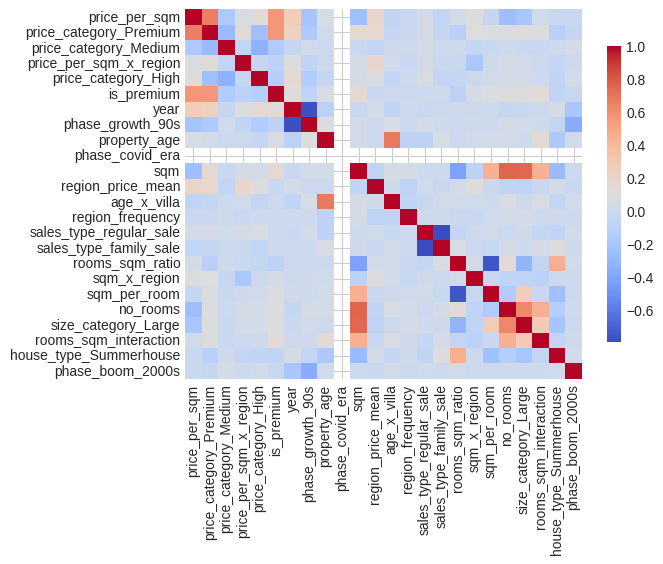

In [30]:

sns.heatmap(X_train.corr(), annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})


In [32]:
#obtener las mas altas correlaciones
correlation_matrix = X_train.corr()
high_correlation = correlation_matrix[abs(correlation_matrix) > 0.8].stack().reset_index()
high_correlation.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation = high_correlation[high_correlation['Feature 1'] != high_correlation['Feature 2']]
high_correlation = high_correlation.sort_values(by='Correlation', ascending=False)

if high_correlation.empty:
    print("No hay correlaciones altas (>0.8) entre las variables.")
else:
    print("Correlaciones altas (>0.8) entre las variables:")
    print(high_correlation)

No hay correlaciones altas (>0.8) entre las variables.


In [34]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

train_h2o = h2o.H2OFrame(df_train)
test_h2o = h2o.H2OFrame(df_test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [36]:

train_h2o[TARGET] = train_h2o[TARGET].asnumeric()
test_h2o[TARGET] = test_h2o[TARGET].asnumeric()

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial, features, target, train_h2o, test_h2o):
    params = {
        "ntrees": trial.suggest_int("ntrees", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learn_rate": trial.suggest_float("learn_rate", 0.01, 0.2),
        "col_sample_rate": trial.suggest_float("col_sample_rate", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_rows": trial.suggest_int("min_rows", 1, 10),
        "backend": "gpu",  
        "seed": 42
    }

    model = H2OXGBoostEstimator(**params)
    model.train(x=features, y=target, training_frame=train_h2o)

    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[target].as_data_frame().values.ravel()
    


    rmse = np.sqrt(mean_squared_error(true, preds))
    return rmse

    

# ⛓️ WRAP con partial
objective_fn = partial(
    objective,
    features=features,
    target=TARGET,
    train_h2o=train_h2o,
    test_h2o=test_h2o
)



In [38]:

study_name = "h2o_xgb_gpu_tuning2"
storage_url = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_url,
    load_if_exists=True
)

study.optimize(objective_fn, n_trials=10)

print("✅ Best trial:")
print(study.best_trial.params)

[I 2025-07-13 17:59:05,706] A new study created in RDB with name: h2o_xgb_gpu_tuning2


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 17:59:14,009] Trial 0 finished with value: 0.020907814825999144 and parameters: {'ntrees': 180, 'max_depth': 5, 'learn_rate': 0.18786623487681164, 'col_sample_rate': 0.9619337624563113, 'subsample': 0.8684142088863964, 'min_rows': 6}. Best is trial 0 with value: 0.020907814825999144.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 17:59:21,565] Trial 1 finished with value: 0.018611352086989042 and parameters: {'ntrees': 109, 'max_depth': 7, 'learn_rate': 0.11085673264104369, 'col_sample_rate': 0.9205826959627367, 'subsample': 0.7295171160157614, 'min_rows': 1}. Best is trial 1 with value: 0.018611352086989042.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 17:59:29,671] Trial 2 finished with value: 0.01784530170466193 and parameters: {'ntrees': 110, 'max_depth': 8, 'learn_rate': 0.07512519995072363, 'col_sample_rate': 0.7929042892597601, 'subsample': 0.7278548422166464, 'min_rows': 7}. Best is trial 2 with value: 0.01784530170466193.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 17:59:37,999] Trial 3 finished with value: 0.6157220435195203 and parameters: {'ntrees': 132, 'max_depth': 9, 'learn_rate': 0.02340446669245424, 'col_sample_rate': 0.9098915185190437, 'subsample': 0.7374015655491547, 'min_rows': 3}. Best is trial 2 with value: 0.01784530170466193.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 17:59:46,424] Trial 4 finished with value: 0.025736765502505934 and parameters: {'ntrees': 275, 'max_depth': 4, 'learn_rate': 0.1284733360404252, 'col_sample_rate': 0.8671719772099783, 'subsample': 0.7827997893495956, 'min_rows': 2}. Best is trial 2 with value: 0.01784530170466193.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 18:00:14,911] Trial 5 finished with value: 0.011192223694646744 and parameters: {'ntrees': 293, 'max_depth': 11, 'learn_rate': 0.19788315549913754, 'col_sample_rate': 0.6451009550200308, 'subsample': 0.9812329684396147, 'min_rows': 7}. Best is trial 5 with value: 0.011192223694646744.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 18:00:22,790] Trial 6 finished with value: 0.024550317808274758 and parameters: {'ntrees': 165, 'max_depth': 5, 'learn_rate': 0.1638073820573037, 'col_sample_rate': 0.6334155468873487, 'subsample': 0.8519670559583405, 'min_rows': 9}. Best is trial 5 with value: 0.011192223694646744.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 18:00:33,523] Trial 7 finished with value: 0.014505804332723046 and parameters: {'ntrees': 275, 'max_depth': 7, 'learn_rate': 0.10546715151050277, 'col_sample_rate': 0.8055990393903201, 'subsample': 0.7836529599915677, 'min_rows': 6}. Best is trial 5 with value: 0.011192223694646744.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 18:00:40,967] Trial 8 finished with value: 0.053095731983005934 and parameters: {'ntrees': 222, 'max_depth': 4, 'learn_rate': 0.06267423782395828, 'col_sample_rate': 0.927745358859416, 'subsample': 0.6007115792806755, 'min_rows': 8}. Best is trial 5 with value: 0.011192223694646744.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 18:00:55,027] Trial 9 finished with value: 0.013026271485996985 and parameters: {'ntrees': 105, 'max_depth': 12, 'learn_rate': 0.09845323663417027, 'col_sample_rate': 0.6071408414089373, 'subsample': 0.7179746433008256, 'min_rows': 3}. Best is trial 5 with value: 0.011192223694646744.


✅ Best trial:
{'ntrees': 293, 'max_depth': 11, 'learn_rate': 0.19788315549913754, 'col_sample_rate': 0.6451009550200308, 'subsample': 0.9812329684396147, 'min_rows': 7}


In [ ]:
study.best_trial.params

{'ntrees': 247,
 'max_depth': 12,
 'learn_rate': 0.0917447797916672,
 'col_sample_rate': 0.9858146205522978,
 'subsample': 0.6735041310585524,
 'min_rows': 3}

In [43]:
best_params = study.best_trial.params
best_model = H2OXGBoostEstimator(**best_params)
best_model.train(x=features, y=TARGET, training_frame=train_h2o)
best_model_path = best_model.save_mojo(path="models/", force=True)
print(f"📦 Modelo guardado en: {best_model_path}")


xgboost Model Build progress: |

██████████████████████████████████████████████████| (done) 100%
📦 Modelo guardado en: /home/exodia/Documentos/TFBigData/models/XGBoost_model_python_1752446897284_11.zip


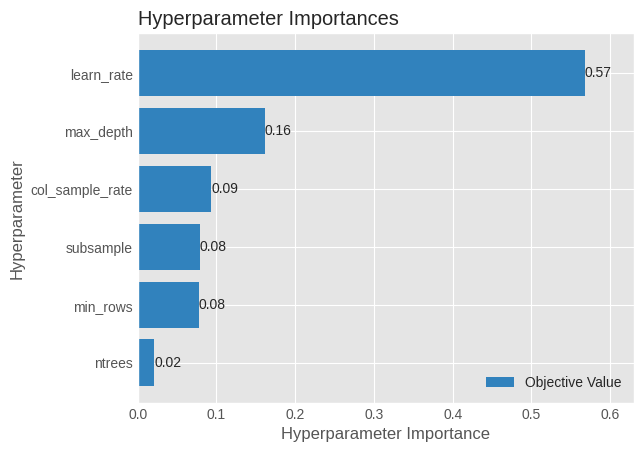

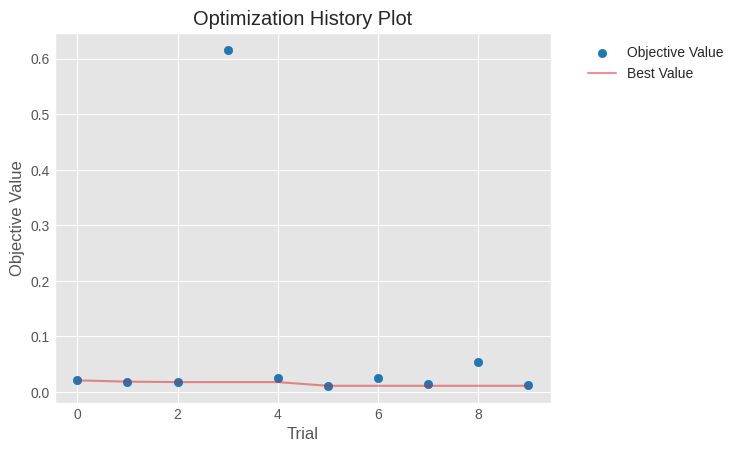

In [41]:
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history
import matplotlib.pyplot as plt

plot_param_importances(study)
plt.show()

plot_optimization_history(study)
plt.show()


In [44]:
evaluation = best_model.model_performance(test_data=test_h2o)
print("RMSE en test:", evaluation.rmse())

RMSE en test: 0.010865463097900265


In [45]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    max_runtime_secs=600,           # ⏱️ tiempo total (ajustá según tu disponibilidad)
    seed=42,
    include_algos=["XGBoost"],      # ⚡ Solo modelos con soporte GPU
    sort_metric="RMSE",            # O 'MAE', 'R2', etc.
    keep_cross_validation_predictions=True
)

aml.train(x=features, y=TARGET, training_frame=train_h2o)


AutoML progress: |
18:03:43.609: _train param, Dropping bad and constant columns: [phase_covid_era]

█████████████████████████████████████████████████████████
18:12:50.482: _train param, Dropping bad and constant columns: [phase_covid_era]

██████| (done) 100%

18:13:43.420: _train param, Dropping bad and constant columns: [phase_covid_era]



Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250713_180343


Model Summary: 
    number_of_trees
--  -----------------
    166

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 4.217525135801535e-05
RMSE: 0.006494247559033714
MAE: 0.004729041440171327
RMSLE: 0.000439009012097105
Mean Residual Deviance: 4.217525135801535e-05

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.00016722584456891598
RMSE: 0.012931583219734387
MAE: 0.006987655344018711
RMSLE: 0.0008803139743825442
Mean Residual Deviance: 0.00016722584456891598

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan          0            nan           nan           nan           nan           nan
loglikelihood           nan          0            nan           nan           nan           nan           nan
mae                     0.00698766   0.000313918  0.00701447    0.0067741     0.0068182     0.00752331    0.00680819
mean_residual_deviance  0.000167226  1.22074e-05  0.000174132   0.000151798   0.000164411   0.000183807   0.000161982
mse                     0.000167226  1.22074e-05  0.000174132   0.000151798   0.000164411   0.000183807   0.000161982
r2                      0.9997       2.1246e-05   0.999688      0.999727      0.999705      0.999671      0.999709
residual_deviance       0.000167226  1.22074e-05  0.000174132   0.000151798   0.000164411   0.000183807   0.000161982
rmse                    0.0129247    0.000471289  0.0131959     0.0123206     0.0128223     0.0135576     0.0127272
rmsle                   0.000879857  3.1717e-05   0.00089629    0.000841165   0.000871462   0.000924479   0.000865887

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse          training_mae          training_deviance
---  -------------------  ----------------  -----------------  ---------------------  --------------------  ----------------------
     2025-07-13 18:11:49  8 min  5.497 sec  0.0                13.494937743012473     13.474267105859992    182.1133446877826
     2025-07-13 18:11:49  8 min  5.930 sec  5.0                2.270812555406149      2.265259774717739     5.156589661790203
     2025-07-13 18:11:49  8 min  6.139 sec  10.0               0.38459732271915564    0.38119539156637416   0.14791510064274235
     2025-07-13 18:11:50  8 min  6.858 sec  15.0               0.06843115080199114    0.0647351693344212    0.004682822400084853
     2025-07-13 18:11:51  8 min  8.097 sec  20.0               0.020577946771082177   0.015496611581272272  0.0004234518933134914
     2025-07-13 18:11:52  8 min  9.137 sec  25.0               0.015398014175667557   0.010961327974665959  0.00023709884055405904
     2025-07-13 18:11:53  8 min 10.092 sec  30.0               0.01397192581784911    0.009874875243375424  0.0001952147110594785
     2025-07-13 18:11:54  8 min 11.156 sec  35.0               0.012817358222186947   0.009000952542855923  0.00016428467179586335
     2025-07-13 18:11:55  8 min 12.065 sec  40.0               0.012202227286189056   0.008631346537304255  0.00014889435074381675
     2025-07-13 18:11:56  8 min 13.090 sec  45.0               0.011559555483517786   0.008170169198255368  0.00013362332297652612
---  ---                  ---               ---                ---                    ---                   ---
     2025-07-13 18:12:22  8 min 38.559 sec  125.0              0.0074486613476347245  0.005357272220974081  5.548255587174755e-05
     2025-07-13 18:12:24  8 min 40.942 sec  130.0              0.00732086913862468    0.005282655388346683  5.359512494486726e-05
     2025-07-13 18:12:27  8 min 43.454 sec  135.0              0.007178763424604341   0.005176960864035599  5.153464430643704

In [46]:
# Evaluar en test_h2o
perf_automl = aml.leader.model_performance(test_h2o)
print("🔍 AutoML RMSE:", perf_automl.rmse())

# Comparar con Optuna-tuneado
perf_optuna = best_model.model_performance(test_h2o)
print("🎯 Optuna RMSE:", perf_optuna.rmse())



🔍 AutoML RMSE: 0.01285289864029561
🎯 Optuna RMSE: 0.010865463097900265


In [47]:
# ==================================================
# 📊 EVALUACIÓN COMPRENSIVA DE MODELOS
# ==================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_mape(y_true, y_pred):
    """Calcula MAPE evitando división por cero"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model, test_h2o, model_name):
    """Evalúa un modelo H2O y retorna métricas"""
    # Predicciones
    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[TARGET].as_data_frame().values.ravel()
    
    # Métricas
    rmse = np.sqrt(mean_squared_error(true, preds))
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    mape = calculate_mape(true, preds)
    
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Predicciones': preds,
        'Reales': true
    }

# Evaluar ambos modelos
results = []
results.append(evaluate_model(best_model, test_h2o, "XGBoost Optuna"))
results.append(evaluate_model(aml.leader, test_h2o, "AutoML Leader"))

print("✅ Evaluación completada")

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
✅ Evaluación completada


🏆 COMPARACIÓN DE MODELOS:
        Modelo   RMSE    MAE     R²  MAPE (%)
XGBoost Optuna 0.0109 0.0062 0.9998    0.0426
 AutoML Leader 0.0129 0.0075 0.9997    0.0516

🥇 Mejor modelo: XGBoost Optuna


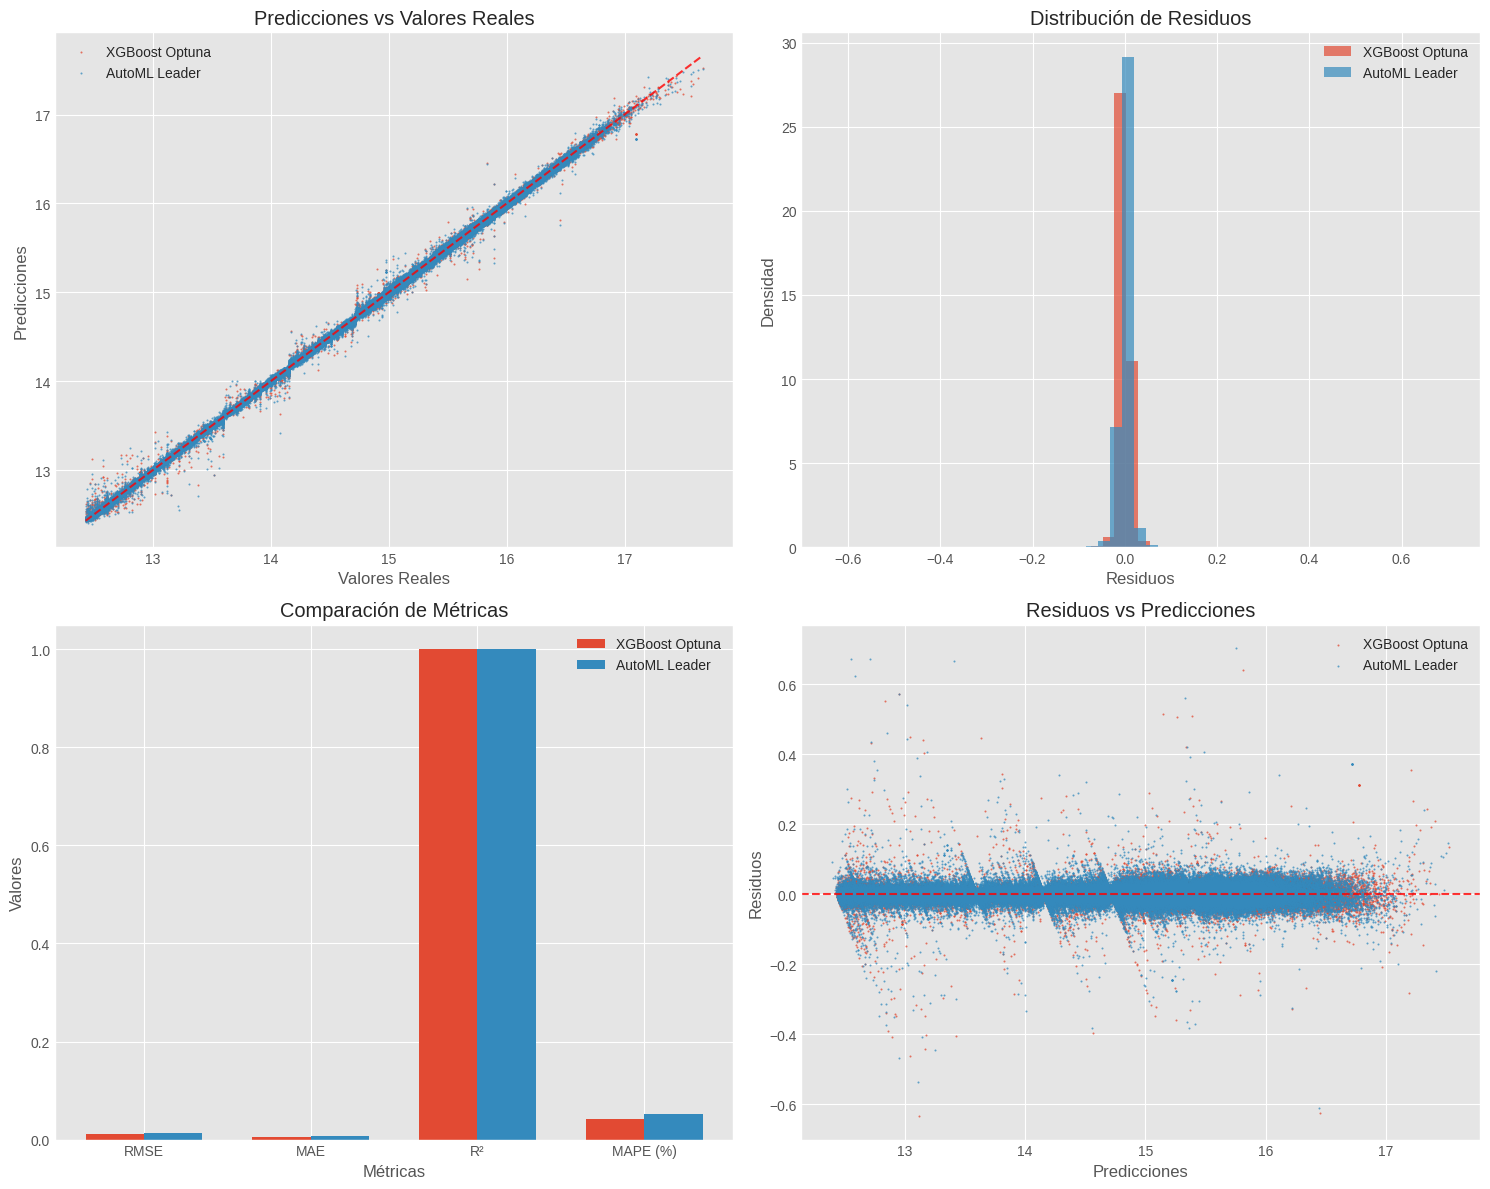

In [48]:
# ==================================================
# 📈 TABLA COMPARATIVA Y VISUALIZACIONES
# ==================================================

# Crear tabla comparativa
comparison_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R²', 'MAPE (%)']]
comparison_df = comparison_df.round(4)

print("🏆 COMPARACIÓN DE MODELOS:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo
best_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.iloc[best_idx]['Modelo']
print(f"\n🥇 Mejor modelo: {best_model_name}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Reales
for i, result in enumerate(results):
    axes[0, 0].scatter(result['Reales'], result['Predicciones'], 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[0, 0].plot([min(results[0]['Reales']), max(results[0]['Reales'])], 
                [min(results[0]['Reales']), max(results[0]['Reales'])], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Predicciones vs Valores Reales')
axes[0, 0].legend()

# 2. Distribución de Residuos
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, label=result['Modelo'], density=True)
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Densidad')
axes[0, 1].set_title('Distribución de Residuos')
axes[0, 1].legend()

# 3. Métricas comparativas
metrics = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
x_pos = np.arange(len(metrics))
width = 0.35

for i, result in enumerate(results):
    values = [comparison_df.iloc[i]['RMSE'], comparison_df.iloc[i]['MAE'], 
              comparison_df.iloc[i]['R²'], comparison_df.iloc[i]['MAPE (%)']]
    axes[1, 0].bar(x_pos + i*width, values, width, label=result['Modelo'])

axes[1, 0].set_xlabel('Métricas')
axes[1, 0].set_ylabel('Valores')
axes[1, 0].set_title('Comparación de Métricas')
axes[1, 0].set_xticks(x_pos + width/2)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()

# 4. Residuos vs Predicciones
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[1, 1].scatter(result['Predicciones'], residuals, 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Predicciones')
axes[1, 1].set_ylabel('Residuos')
axes[1, 1].set_title('Residuos vs Predicciones')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

🔍 IMPORTANCIA DE VARIABLES:
              variable  relative_importance  scaled_importance  percentage
         price_per_sqm        463446.000000           1.000000    0.346005
price_category_Premium        434426.250000           0.937383    0.324339
   price_category_High        216712.765625           0.467612    0.161796
 price_category_Medium        103129.718750           0.222528    0.076996
                   sqm         63209.941406           0.136391    0.047192
            is_premium         24022.611328           0.051835    0.017935
   size_category_Large         12398.930664           0.026754    0.009257
price_per_sqm_x_region          7852.067871           0.016943    0.005862
                  year          7814.895020           0.016863    0.005835
          sqm_x_region          3977.947998           0.008583    0.002970


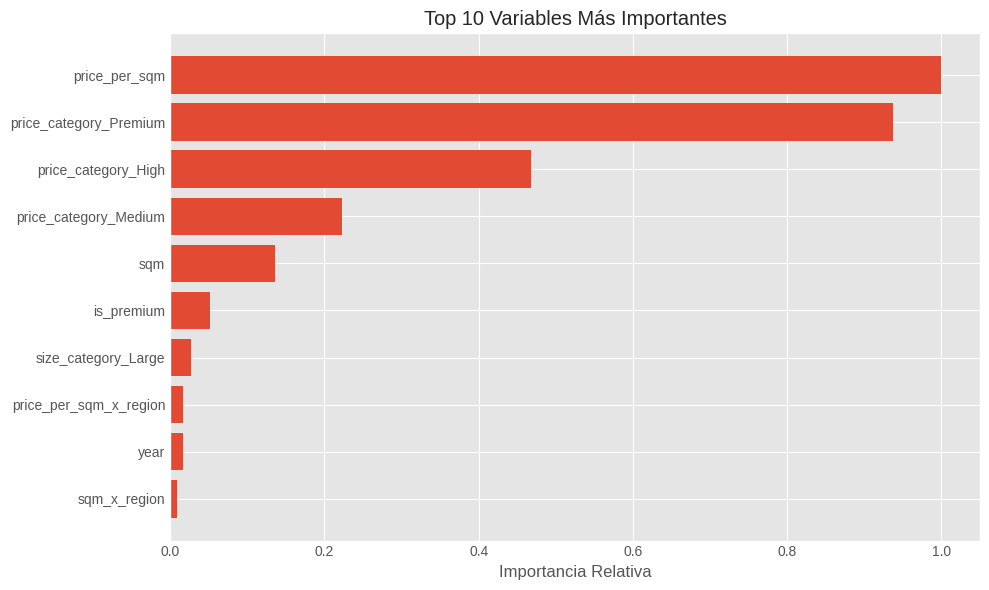


💾 Resultados guardados en: results/model_evaluation_summary.json
📊 Muestras evaluadas: 613,479
✅ Evaluación completa finalizada


In [49]:
# ==================================================
# 🎯 ANÁLISIS DE IMPORTANCIA Y RESUMEN FINAL
# ==================================================

# Feature Importance del mejor modelo
print("🔍 IMPORTANCIA DE VARIABLES:")
print("=" * 40)

# Obtener importancia de variables
varimp = best_model.varimp(use_pandas=True)
top_features = varimp.head(10)

print(top_features.to_string(index=False))

# Visualizar importancia
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['scaled_importance'])
plt.yticks(range(len(top_features)), top_features['variable'])
plt.xlabel('Importancia Relativa')
plt.title('Top 10 Variables Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar resultados
results_summary = {
    'best_model': best_model_name,
    'metrics': comparison_df.to_dict('records'),
    'feature_importance': top_features.to_dict('records'),
    'total_test_samples': len(results[0]['Reales'])
}

# Guardar en archivo
import json
with open('results/model_evaluation_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n💾 Resultados guardados en: results/model_evaluation_summary.json")
print(f"📊 Muestras evaluadas: {results_summary['total_test_samples']:,}")
print("✅ Evaluación completa finalizada")